In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
import scipy.stats as stats

pio.renderers.default = 'colab' # vscode
pio.templates.default = 'plotly'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
aapl_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_2023/AAPL.csv')
btc_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_2023/BTC.csv')
gas_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_2023/GAS.csv')
aapl_df['date'] = aapl_df['date'].apply(lambda x: pd.to_datetime(x))
btc_df['date'] = btc_df['date'].apply(lambda x: pd.to_datetime(x))
gas_df['Date'] = gas_df['Date'].apply(lambda x: pd.to_datetime(x))

In [ ]:
btc_df

,date,Open,High,Low,Close,Volume
0,2019-09-23,10028.05,10049.99,9615.77,9702.25,31937.232356
1,2019-09-24,9702.20,9794.99,7800.00,8493.14,94007.345203
2,2019-09-25,8497.55,8730.00,8215.64,8430.05,60783.892258
3,2019-09-26,8430.05,8465.99,7750.00,8063.73,67930.853749
4,2019-09-27,8063.49,8265.00,7852.15,8177.91,43882.924625
...,...,...,...,...,...,...
1254,2023-02-28,23492.09,23600.00,23020.97,23141.57,264140.998940
1255,2023-03-01,23141.57,24000.00,23020.03,23628.97,315287.417370
1256,2023-03-02,23629.76,23796.93,23195.90,23465.32,239315.452190
1257,2023-03-03,23465.32,23476.95,21971.13,22354.34,319954.197850


In [ ]:
fig = px.scatter(data_frame=aapl_df, x='date', y='Adj Close', trendline='ols', title='AAPL')
fig.show()


In [ ]:
px.scatter(data_frame=btc_df, x='date', y='Close', trendline='ols', title='BTC')

In [ ]:
fig = px.scatter(data_frame=gas_df, x='Date', y='Close', trendline='ols', title='GAS(N.NG)')
fig.show()


### 1. На основе Close извлеките логарифмическую доходность BTC task1, ответ – мю и сигма


In [ ]:
# проверим распределение цен закрытия визуально: ожидается правостороннее распределение
fig = px.histogram(btc_df, 'Close', title='Distribution of Close')
fig.show()

In [ ]:
# величина Close похожа на ту, что имеет лог-нормальное распределение, посчитаем лог-доходности по PnL
btc_close_pnl = btc_df.Close.pct_change().iloc[1:]
btc_close_logr = np.log(btc_close_pnl+1)
print('mu:', round(btc_close_logr.mean(), 3), '\nstd:', round(btc_close_logr.std(), 3))

mu: 0.001 
std: 0.039


### 2.Проверьте распределение получившихся данных BTC task2, ответ yes/no

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
# помотрим на распределение лог-доходностей btc_close
fig = px.histogram(btc_close_logr, title='Distribution of Close')
fig.show()

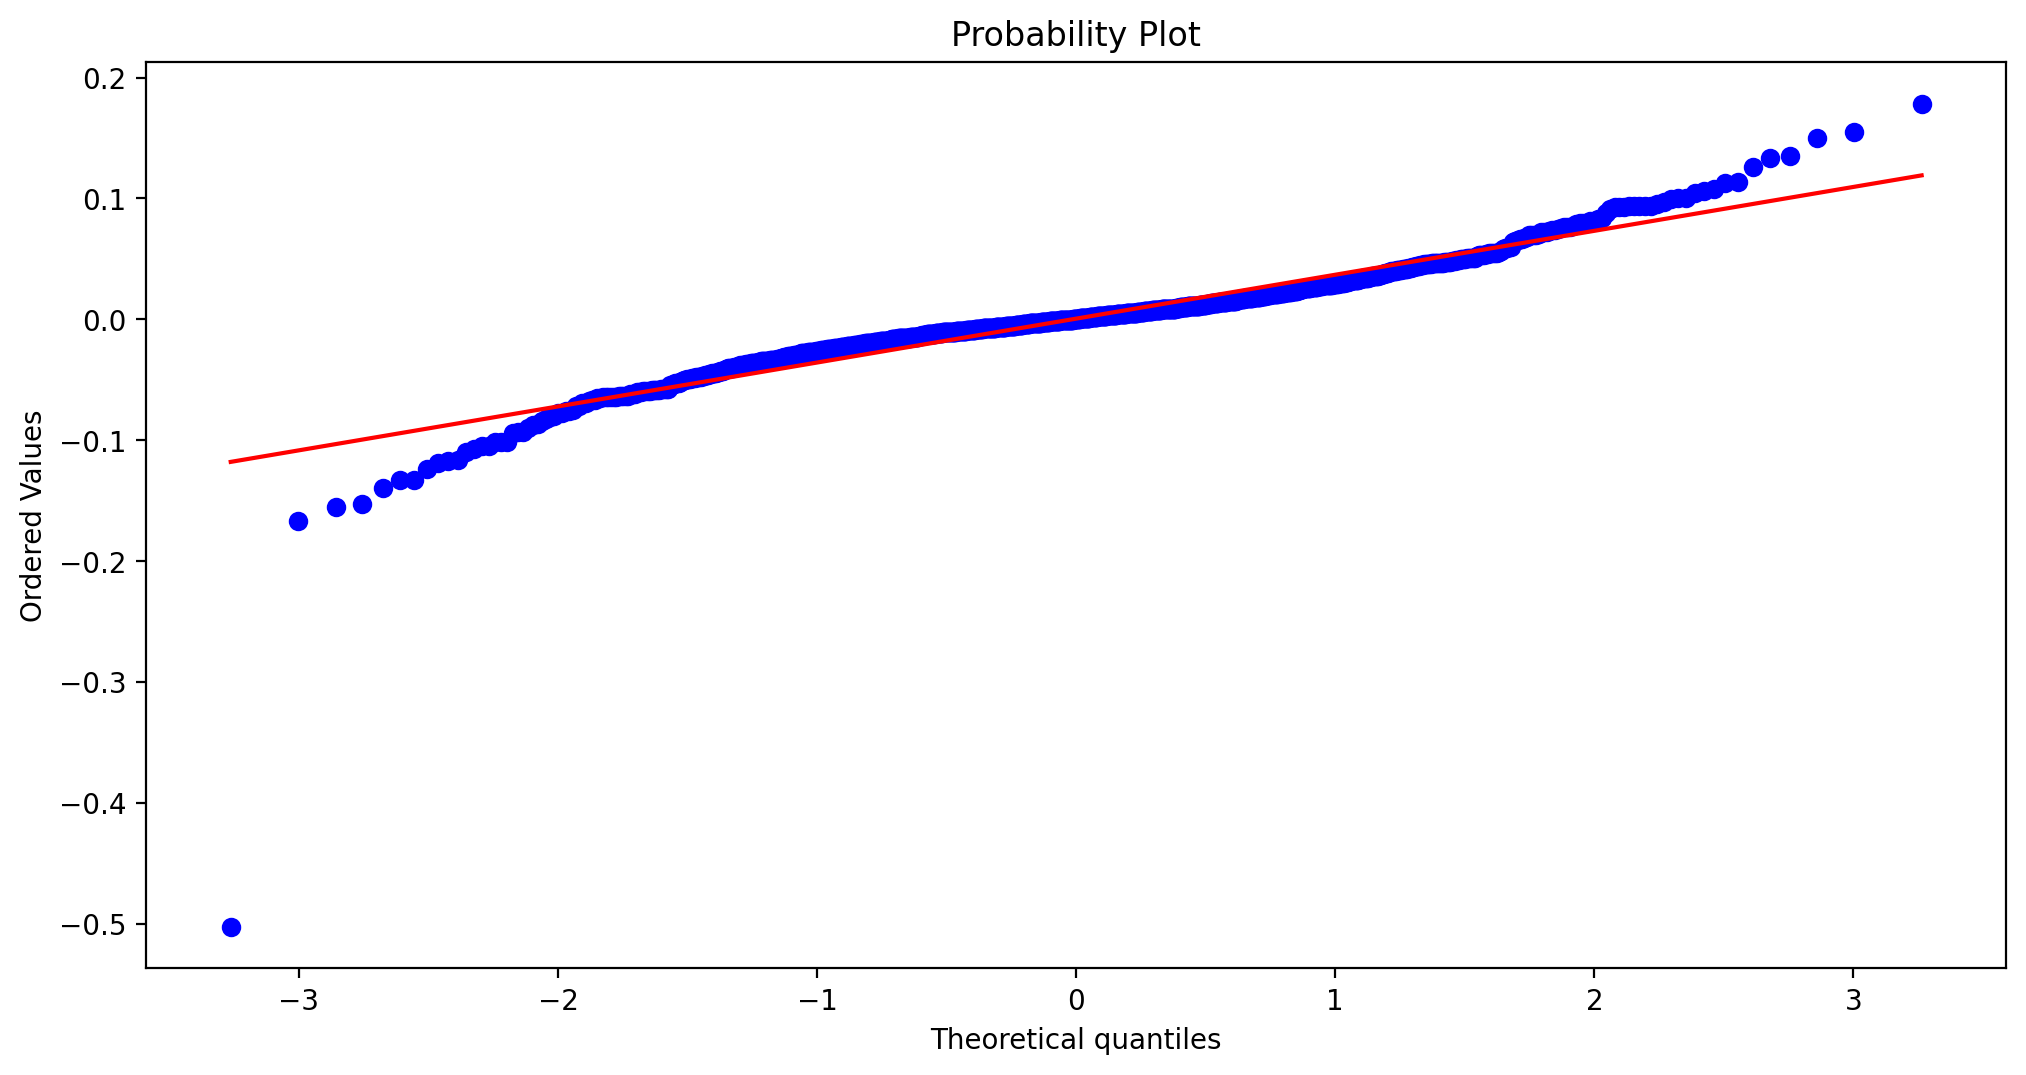

In [ ]:
# график квантиль-квантиль намекает на нормальное распределение btc_close_r
plt.subplots(figsize=(12, 6), dpi=100)
stats.probplot(btc_close_logr, dist='norm', plot=plt)
plt.show;

In [ ]:
# проверим эту гипотезу через тест Шапиро-Уилка
SW_test = pd.DataFrame(stats.shapiro(btc_close_logr), columns=['value'],
                       index=['SW test statistic', 'SW test p-value'])

print('\n --- The Shapiro-Wilk normality test ---')
print(SW_test)


 --- The Shapiro-Wilk normality test ---
                          value
SW test statistic  8.816498e-01
SW test p-value    6.439466e-30


p-value < 5%: не отвергаем основную гипотезу о нормальности распределения лог-доходностей цен закрытия BTC

### 3. Попробуйте их (BTC) нормализовать task3, ответ – mu и sigma

In [ ]:
# так как выснили, что лог-доходности статистически следуют нормальному распределению, можно применить к ним z-номализацию через среднее и СКО
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler().fit(pd.DataFrame(btc_close_logr))
btc_close_logr_std_scaled = std_scaler.transform(pd.DataFrame(btc_close_logr))
print('mu:', round(btc_close_logr_std_scaled.mean(), 3), '\nsigma:', round(btc_close_logr_std_scaled.std(), 3))

mu: 0.0 
sigma: 1.0


### 4. Попробуйте предположить по подвыборке размером 634 дней среднее значение для доходностей (BTC) на уровне 90 95 99 – task 4, ответ – val + [a;b]

In [ ]:
import random
random.seed(1903)
btclogr_samp = random.sample(sorted(btc_close_logr), 634)

In [ ]:
btclogr_samp[0:10]

[-0.011277353573673094,
 -0.000580361234278455,
 -0.012450835212587299,
 -0.058927885424531284,
 0.016504674065094656,
 -0.06308249760374372,
 0.022752101931693153,
 0.014565304906857087,
 0.042921922045645745,
 -0.0636651051045502]

In [ ]:
average = np.mean(btclogr_samp)

In [ ]:
# доверительные интервалы для 90%б 95%, 99%
from scipy.stats import norm

bottom_90 = norm.ppf((1-0.90)/2, 0, 1)*np.std(btclogr_samp)/634**0.5
bottom_95 = norm.ppf((1-0.95)/2, 0, 1)*np.std(btclogr_samp)/634**0.5
bottom_99 = norm.ppf((1-0.99)/2, 0, 1)*np.std(btclogr_samp)/634**0.5

In [ ]:
print('Выб. среднее', round(average, 3))
print('---'*3,'90% доверительный интервал','---'*3, '\n', (round(average+bottom_90, 3), round(average-bottom_90, 3)))
print('---'*3,'95% доверительный интервал','---'*3, '\n', (round(average+bottom_95, 3), round(average-bottom_95, 3)))
print('---'*3,'99% доверительный интервал','---'*3, '\n', (round(average+bottom_99, 3), round(average-bottom_99, 3)))

Выб. среднее -0.001
--------- 90% доверительный интервал --------- 
 (-0.003, 0.002)
--------- 95% доверительный интервал --------- 
 (-0.004, 0.003)
--------- 99% доверительный интервал --------- 
 (-0.005, 0.004)


### 5. Проверьте корреляцию доходностей BTC & AAPL – task5, ответ – yes/no

In [ ]:
df_new = aapl_df[['date', 'Close']].merge(btc_df[['date', 'Close']], how='inner', on='date', suffixes=['_aapl', '_btc'])

In [ ]:
# проверяем, всё ли замерджилось
df_new.isna().sum()

date          0
Close_aapl    0
Close_btc     0
dtype: int64

In [ ]:
df_new.head()

,date,Close_aapl,Close_btc
0,2019-09-23,53.326996,9702.25
1,2019-09-24,53.073425,8493.14
2,2019-09-25,53.890209,8430.05
3,2019-09-26,53.612263,8063.73
4,2019-09-27,53.351383,8177.91


In [ ]:
log_r = np.log(df_new[['Close_aapl', 'Close_btc']].pct_change().iloc[1:]+1)
log_r.head()

,Close_aapl,Close_btc
1,-0.004766,-0.133099
2,0.015272,-0.007456
3,-0.005171,-0.044426
4,-0.004878,0.014060
5,0.023263,0.013534


In [ ]:
#  по диаграмме рассеяния линейную связь между лог-доходностями усмотреть можно
fig = px.scatter(log_r, x="Close_aapl", y="Close_btc", trendline="ols")
fig.update_layout(title_text="Depenedence AAPL on BTC, $")
fig.update_xaxes(title='Close_aapl')
fig.show()

In [ ]:
coefPears, pvPears= stats.pearsonr(log_r.Close_aapl, log_r.Close_btc)

print("Pearson's correlation = ", round(coefPears,3))
print("Pearson's p-value = ", round(pvPears,3))

Pearson's correlation =  0.336
Pearson's p-value =  0.0


Статистически значимый коэффициент корреляции указывает на наличие слабой положительной взаимозависимости между лог. доходностями AAPL & BTC

### 6. Проверьте гипотезу о равенствен средних и дисперсии доходностей BTC & AAPL & GAS – task6, ответ – yes/no

In [ ]:
# сначала рассчитаем лог-доходности
gas = np.log(gas_df.Close.pct_change().iloc[1:]+1)
gas=pd.concat([gas, gas_df.Date], axis=1)
gas.head()

,Close,Date
1,-0.009543,2019-09-24
2,-0.000400,2019-09-25
3,-0.030023,2019-09-26
4,-0.009934,2019-09-27
5,-0.031266,2019-09-30


In [ ]:
gas.columns=['Close_gas', 'date']
gas.head()

,Close_gas,date
1,-0.009543,2019-09-24
2,-0.000400,2019-09-25
3,-0.030023,2019-09-26
4,-0.009934,2019-09-27
5,-0.031266,2019-09-30


In [ ]:
df_6 = df_new.merge(gas, how='inner', on='date')

In [ ]:
# очистим df от пустых значений, появившихся при смёрдживании
df_6.isna().sum()

date          0
Close_aapl    0
Close_btc     0
Close_gas     1
dtype: int64

In [ ]:
df_6 = df_6[df_6.Close_gas.isna()==False]

In [ ]:
df_6.isna().sum()

date          0
Close_aapl    0
Close_btc     0
Close_gas     0
dtype: int64

In [ ]:
df_6.head()

,date,Close_aapl,Close_btc,Close_gas
1,2019-09-24,53.073425,8493.14,-0.009543
2,2019-09-25,53.890209,8430.05,-0.000400
3,2019-09-26,53.612263,8063.73,-0.030023
4,2019-09-27,53.351383,8177.91,-0.009934
5,2019-09-30,54.607025,8289.34,-0.031266


In [ ]:
# тест Флигнера-Киллина на равенство дисперсий AAPL & BTC & GAS
stat, pVal = stats.fligner(df_6.Close_aapl, df_6.Close_btc , df_6.Close_gas, center='mean')

print("Statistic = ", round(stat,10))
print("P-value = ", round(pVal,10))

Statistic =  2027.7290194984
P-value =  0.0


Таким образом, дисперсии доходностей равны друг другу

In [ ]:
# тесты на равенство средних, попарно, из заключения о равенстве дисперсий
# AAPL & BTC
t_twoind, pVal_twoind = stats.ttest_ind(df_6.Close_aapl, df_6.Close_btc, equal_var=True)

print("t-statistic = ", round(t_twoind,10))
print("p-value = ", round(pVal_twoind,10))

t-statistic =  -46.3839761241
p-value =  0.0


In [ ]:
# AAPL & GAS
t_twoind, pVal_twoind = stats.ttest_ind(df_6.Close_aapl, df_6.Close_gas, equal_var=True)

print("t-statistic = ", round(t_twoind,10))
print("p-value = ", round(pVal_twoind,10))

t-statistic =  106.8485767986
p-value =  0.0


In [ ]:
# BTC & GAS
t_twoind, pVal_twoind = stats.ttest_ind(df_6.Close_btc, df_6.Close_gas, equal_var=True)

print("t-statistic = ", round(t_twoind,10))
print("p-value = ", round(pVal_twoind,10))

t-statistic =  46.5995850106
p-value =  0.0


Для каждой пары выборок проверили гипотезу о равентстве средних: стат. значимо не отвергаем её.

### Ответы

In [ ]:
ANSWERS = {
    'tasks' : {
        'task1_mu' : {
            "answer" : 0.001
        },
        'task1_sigma' : {
            "answer" : 0.039
        },
        'task2_normal' : {
            'answer' : 'yes'
        },
        'task3_mu' : {
            "answer" : 0.0
        },
        'task3_sigma' : {
            "answer" : 1.0
        },
        'task4_90' : {
            "answer" : -0.001
        },
        'task4_90_int' : {
            "answer" : [-0.003, 0.002]
        },
        'task4_95' : {
            "answer" : -0.001
        },
        'task4_95_int' : {
            "answer" : [-0.004, 0.003]
        },
        'task4_99' : {
            "answer" : -0.001
        },
        'task4_99_int' : {
            "answer" : [-0.005, 0.004]
        },
        'task5_corr' : {
            "answer" : "yes"
        },
        'task6_corr_mu' : {
            "answer" : "yes"
        },
        'task6_corr_sigma' : {
            "answer" : "yes"
        }
    }
}


In [ ]:
import yaml
yaml_result = yaml.dump(ANSWERS)

print(yaml_result)

with open(f"hw03.yaml", "w") as f:
    f.write(yaml_result)

tasks:
  task1_mu:
    answer: 0.001
  task1_sigma:
    answer: 0.039
  task2_normal:
    answer: 'yes'
  task3_mu:
    answer: 0.0
  task3_sigma:
    answer: 1.0
  task4_90:
    answer: -0.001
  task4_90_int:
    answer:
    - -0.003
    - 0.002
  task4_95:
    answer: -0.001
  task4_95_int:
    answer:
    - -0.004
    - 0.003
  task4_99:
    answer: -0.001
  task4_99_int:
    answer:
    - -0.005
    - 0.004
  task5_corr:
    answer: 'yes'
  task6_corr_mu:
    answer: 'yes'
  task6_corr_sigma:
    answer: 'yes'

